In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#dataset
from sklearn.datasets import load_iris

#model split
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

#Model selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

#metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

import warnings
warnings.filterwarnings("ignore")

## 1.Problem Statement

In [ ]:
#predict flower

## 2.Data Gathering

In [3]:
iris = load_iris()
df = pd.DataFrame(iris.data,columns = iris.feature_names)
df["target"] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


## 3 EDA

In [3]:
df.info()  #no categorical data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [4]:
df.isna().sum() #no null value

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

<AxesSubplot:>

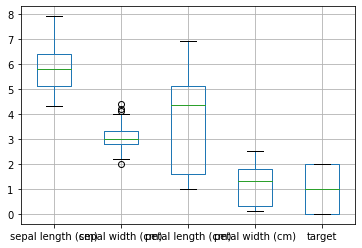

In [5]:
df.boxplot() # outliers in sepal width

<AxesSubplot:xlabel='sepal length (cm)', ylabel='Density'>

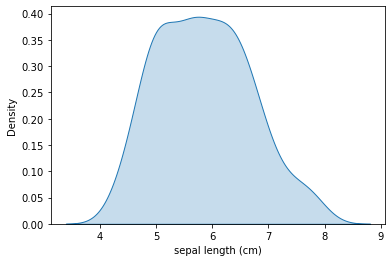

In [58]:
sns.kdeplot(df["sepal length (cm)"],fill = True)

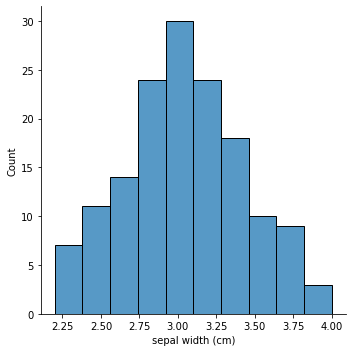

In [59]:
sns.displot(df["sepal width (cm)"])

<AxesSubplot:xlabel='petal length (cm)', ylabel='Density'>

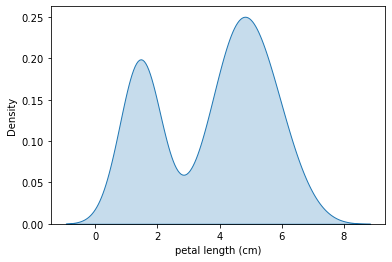

In [62]:
sns.kdeplot(df["petal length (cm)"],fill = True)

<AxesSubplot:xlabel='petal width (cm)', ylabel='Density'>

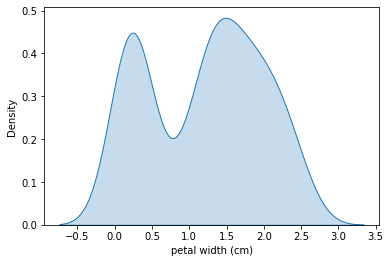

In [66]:
sns.kdeplot(df["petal width (cm)"],fill = True)

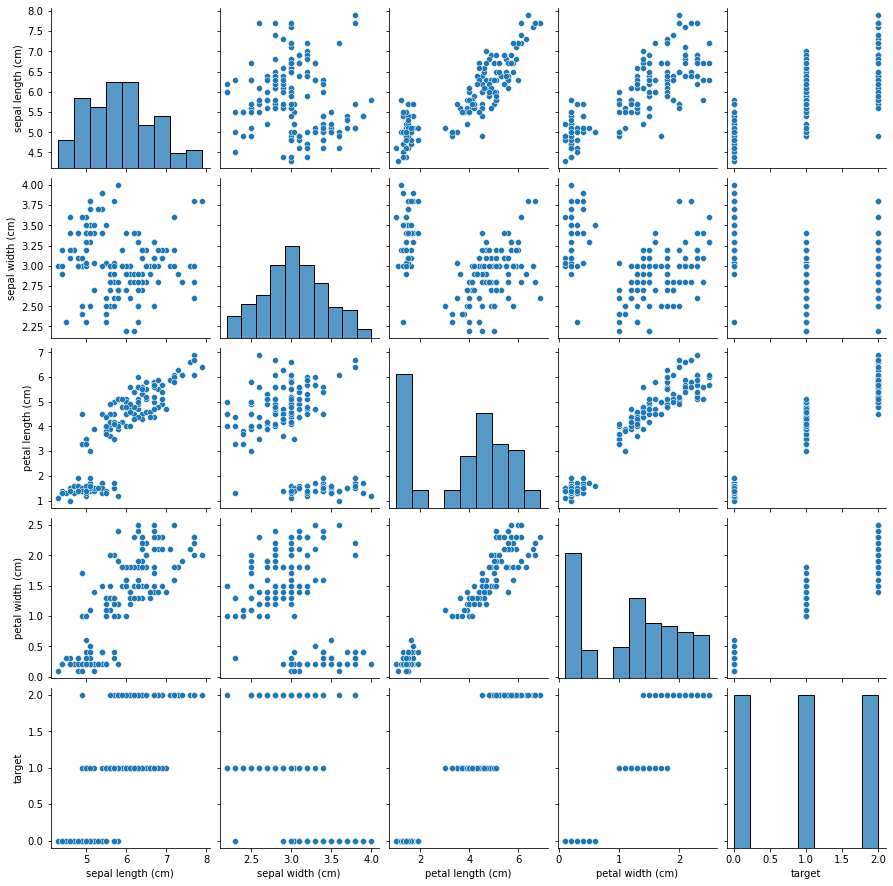

In [11]:
sns.pairplot(df)

## 4 Feature Engineering

In [6]:
q1 = df["sepal width (cm)"].quantile(0.25)
q2 = df["sepal width (cm)"].quantile(0.50)
q3 = df["sepal width (cm)"].quantile(0.75)

IQR = q3-q1
uppertail = q3 + (1.5*IQR)
lowertail = q1 - (1.5*IQR)
df.loc[(df["sepal width (cm)"]>uppertail) | (df["sepal width (cm)"] < lowertail)]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
15,5.7,4.4,1.5,0.4,0
32,5.2,4.1,1.5,0.1,0
33,5.5,4.2,1.4,0.2,0
60,5.0,2.0,3.5,1.0,1


In [7]:
spl_mean = df["sepal width (cm)"].loc[(df["sepal width (cm)"]<=uppertail) & (df["sepal width (cm)"] >= lowertail)].mean()
spl_mean

3.0404109589041104

In [8]:
df["sepal width (cm)"] = np.where((df["sepal width (cm)"]>uppertail) | (df["sepal width (cm)"] < lowertail),spl_mean,df["sepal width (cm)"])


<AxesSubplot:xlabel='sepal width (cm)'>

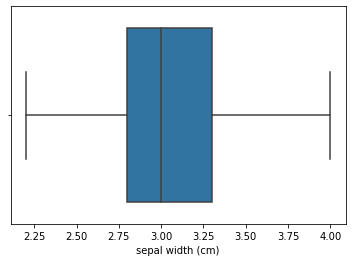

In [9]:
sns.boxplot(df["sepal width (cm)"])

## 5 Feature Selection

### 5.1 Kendall

In [12]:
corr = df.corr(method="kendall").tail(1)
corr

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
target,0.670444,-0.326032,0.822911,0.839687,1.0


<AxesSubplot:>

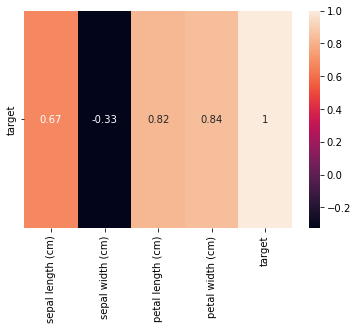

In [13]:
sns.heatmap(corr,annot = True)  #sepal width (cm) less corelation

### 5.2  AnovaTest

In [14]:
from sklearn.feature_selection import f_classif

In [15]:
x = pd.DataFrame(load_iris().data,columns = load_iris().feature_names)
y = pd.Series(load_iris().target)

In [16]:
f_val,p_val = f_classif(x,y) 
df1 = pd.DataFrame({"f_value":f_val,"p_value":np.around(p_val,4)},index = x.columns)
df1  #f_value less so dropit


,f_value,p_value
sepal length (cm),119.264502,0.0
sepal width (cm),49.160040,0.0
petal length (cm),1180.161182,0.0
petal width (cm),960.007147,0.0


In [19]:
vif = pd.DataFrame()
df_1 = df.drop("target",axis = 1)
vif["features"] = df_1.columns
vif["vif_factor"] = [variance_inflation_factor(df.values,i) for i in range(df_1.shape[1])]
vif


,features,vif_factor
0,sepal length (cm),240.605585
1,sepal width (cm),90.801711
2,petal length (cm),175.525834
3,petal width (cm),69.845265


## Evaluation with feature selection

In [20]:
x1 = df.drop(["target","sepal width (cm)"],axis = 1)
y1 = df["target"]
# x1

#### LogisticRegression

In [21]:
x_train,x_test,y_train,y_test = train_test_split(x1,y1,test_size=0.2,random_state=42,stratify=y)
lgc_model = LogisticRegression()
lgc_model.fit(x_train,y_train)

LogisticRegression()

In [22]:
# feature selection
#training

y_pred_train = lgc_model.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 38  2]
 [ 0  2 38]]
accuracy  0.9666666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      0.95      0.95        40
           2       0.95      0.95      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



In [23]:
# feature selection
#testing

y_pred_test = lgc_model.predict(x_test)

cnf_matrics = confusion_matrix(y_pred_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_pred_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_pred_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
accuracy  1.0
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



#### knn

In [24]:
knn1 =KNeighborsClassifier()
knn1.fit(x_train,y_train)
knn1.score(x_train,y_train)

0.9666666666666667

In [25]:
knn1 =KNeighborsClassifier()
knn1.fit(x_train,y_train)
knn1.score(x_test,y_test)

1.0

### hyperparametr

#### gscv

In [26]:
knn_clf = KNeighborsClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
gscv = GridSearchCV(knn_clf,parameter,cv = 5)
gscv.fit(x_train,y_train)
gscv.best_estimator_

KNeighborsClassifier(n_neighbors=13, p=1)

In [27]:
knn1 =KNeighborsClassifier(n_neighbors=13, p=1)
knn1.fit(x_train,y_train)
knn1.score(x_train,y_train)

0.9666666666666667

In [28]:
knn1 =KNeighborsClassifier(n_neighbors=13, p=1)
knn1.fit(x_test,y_test)
knn1.score(x_test,y_test)

0.9

#### rmscv

In [27]:
knn_clf = KNeighborsClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
rmcv = RandomizedSearchCV(knn_clf,parameter,cv = 5)
rmcv.fit(x_train,y_train)
rmcv.best_estimator_

KNeighborsClassifier(n_neighbors=6, p=1)

In [28]:
knn1 =KNeighborsClassifier(n_neighbors=6, p=1)
knn1.fit(x_train,y_train)
knn1.score(x_train,y_train)

0.9583333333333334

In [30]:
knn1 =KNeighborsClassifier(n_neighbors=6, p=1)
knn1.fit(x_test,y_test)
knn1.score(x_test,y_test)

0.9

## 6 Model Training

### model split

In [29]:
x = df.drop("target",axis = 1)
y = df["target"]

In [30]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

## model 

#### LogisticRegression

In [32]:
from mlxtend.feature_selection import SequentialFeatureSelector


In [33]:
#with feature select
logistic_model = LogisticRegression()
sfs = SequentialFeatureSelector(logistic_model,k_features=3,forward=True,cv = 5 ,n_jobs=-1)
sfs.fit(x_train,y_train)
df1 = pd.DataFrame(sfs.subsets_).T
df1

,feature_idx,cv_scores,avg_score,feature_names
1,"(3,)","[0.9583333333333334, 0.9583333333333334, 1.0, ...",0.966667,"(petal width (cm),)"
2,"(2, 3)","[0.9583333333333334, 0.9583333333333334, 0.958...",0.966667,"(petal length (cm), petal width (cm))"
3,"(0, 2, 3)","[0.9583333333333334, 0.9583333333333334, 0.958...",0.966667,"(sepal length (cm), petal length (cm), petal w..."


In [34]:
logistic_model = LogisticRegression()
logistic_model.fit(x_train,y_train)

LogisticRegression()

## 7 Evaluation

In [35]:
#training

y_pred_train = logistic_model.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 38  2]
 [ 0  1 39]]
accuracy  0.975
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.95      0.96        40
           2       0.95      0.97      0.96        40

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120



In [36]:
#testing

y_pred_test = logistic_model.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
accuracy  0.9666666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



#### KNN

In [37]:
#with feature select

In [38]:
knn =KNeighborsClassifier()
sfs = SequentialFeatureSelector(knn,k_features=3,forward=False,cv = 5 ,n_jobs=-1)
sfs.fit(x_train,y_train)
df2 = pd.DataFrame(sfs.subsets_).T
df2

,feature_idx,cv_scores,avg_score,feature_names
4,"(0, 1, 2, 3)","[0.9166666666666666, 1.0, 0.9583333333333334, ...",0.975,"(sepal length (cm), sepal width (cm), petal le..."
3,"(1, 2, 3)","[0.9166666666666666, 0.9583333333333334, 0.958...",0.966667,"(sepal width (cm), petal length (cm), petal wi..."


In [39]:
knn =KNeighborsClassifier()
sfs = SequentialFeatureSelector(knn,k_features=3,forward=False,cv = 5 ,n_jobs=-1)
sfs.fit(x_test,y_test)
df2 = pd.DataFrame(sfs.subsets_).T
df2

,feature_idx,cv_scores,avg_score,feature_names
4,"(0, 1, 2, 3)","[0.8333333333333334, 1.0, 0.8333333333333334, ...",0.9,"(sepal length (cm), sepal width (cm), petal le..."
3,"(0, 2, 3)","[0.8333333333333334, 1.0, 0.8333333333333334, ...",0.933333,"(sepal length (cm), petal length (cm), petal w..."


In [40]:
# without feature select

In [41]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train,y_train)

KNeighborsClassifier()

In [42]:
#training

y_pred_train = knn_clf.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 38  2]
 [ 0  2 38]]
accuracy  0.9666666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      0.95      0.95        40
           2       0.95      0.95      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



In [43]:
#testing

y_pred_test = knn_clf.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]
accuracy  1.0
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



### Hyperparameter Tuning

### GridSearchCV

In [44]:
#with feature select

In [45]:
knn =KNeighborsClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
gscv = GridSearchCV(knn_clf,parameter,cv = 5)
sfs = SequentialFeatureSelector(gscv,k_features=3,forward=False,cv = 5 ,n_jobs=-1)
sfs.fit(x_train,y_train)
df2 = pd.DataFrame(sfs.subsets_).T
df2

,feature_idx,cv_scores,avg_score,feature_names
4,"(0, 1, 2, 3)","[0.9583333333333334, 0.9583333333333334, 0.958...",0.975,"(sepal length (cm), sepal width (cm), petal le..."
3,"(1, 2, 3)","[0.9583333333333334, 1.0, 0.9583333333333334, ...",0.975,"(sepal width (cm), petal length (cm), petal wi..."


In [46]:
knn =KNeighborsClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
gscv = GridSearchCV(knn_clf,parameter,cv = 5)
sfs = SequentialFeatureSelector(gscv,k_features=3,forward=False,cv = 5 ,n_jobs=-1)
sfs.fit(x_test,y_test)
df2 = pd.DataFrame(sfs.subsets_).T
df2

,feature_idx,cv_scores,avg_score,feature_names
4,"(0, 1, 2, 3)","[0.8333333333333334, 1.0, 0.8333333333333334, ...",0.933333,"(sepal length (cm), sepal width (cm), petal le..."
3,"(0, 2, 3)","[0.8333333333333334, 1.0, 0.8333333333333334, ...",0.933333,"(sepal length (cm), petal length (cm), petal w..."


In [47]:
# without feature select

In [48]:
knn_clf = KNeighborsClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
gscv = GridSearchCV(knn_clf,parameter,cv = 5)
gscv.fit(x_train,y_train)
gscv.best_estimator_

KNeighborsClassifier(n_neighbors=6)

In [49]:
knn_clf1 = KNeighborsClassifier(n_neighbors=6)
knn_clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=6)

In [50]:
#training

y_pred_train = knn_clf1.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 38  2]
 [ 0  2 38]]
accuracy  0.9666666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.95      0.95      0.95        40
           2       0.95      0.95      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



In [51]:
#testing

y_pred_test = knn_clf1.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]
accuracy  0.9666666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



#### RandomizedSearchCV

In [ ]:
#with feature select

In [51]:
knn =KNeighborsClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
rmscv = RandomizedSearchCV(knn_clf,parameter,cv = 5)
sfs = SequentialFeatureSelector(rmscv,k_features=3,forward=False,cv = 5 ,n_jobs=-1)
sfs.fit(x_train,y_train)
df2 = pd.DataFrame(sfs.subsets_).T
df2       #select 2 then accuracy decrese

,feature_idx,cv_scores,avg_score,feature_names
4,"(0, 1, 2, 3)","[0.9583333333333334, 1.0, 0.9583333333333334, ...",0.983333,"(sepal length (cm), sepal width (cm), petal le..."
3,"(1, 2, 3)","[0.9583333333333334, 1.0, 0.9583333333333334, ...",0.975,"(sepal width (cm), petal length (cm), petal wi..."


In [52]:
knn =KNeighborsClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
rmscv = RandomizedSearchCV(knn_clf,parameter,cv = 5)
sfs = SequentialFeatureSelector(rmscv,k_features=3,forward=False,cv = 5 ,n_jobs=-1)
sfs.fit(x_test,y_test)
df2 = pd.DataFrame(sfs.subsets_).T
df2 

,feature_idx,cv_scores,avg_score,feature_names
4,"(0, 1, 2, 3)","[0.8333333333333334, 1.0, 0.8333333333333334, ...",0.9,"(sepal length (cm), sepal width (cm), petal le..."
3,"(1, 2, 3)","[0.8333333333333334, 1.0, 0.8333333333333334, ...",0.933333,"(sepal width (cm), petal length (cm), petal wi..."


In [53]:
#without select feature

In [55]:
knn_clf = KNeighborsClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
rmcv = RandomizedSearchCV(knn_clf,parameter,cv = 5)
rmcv.fit(x_train,y_train)
rmcv.best_estimator_

KNeighborsClassifier(n_neighbors=12, p=1)

In [56]:
knn_clf2 = KNeighborsClassifier(n_neighbors=12, p=1)
knn_clf2.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=12, p=1)

In [57]:
#training

y_pred_train = knn_clf2.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 38  2]
 [ 0  1 39]]
accuracy  0.975
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.95      0.96        40
           2       0.95      0.97      0.96        40

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120



In [58]:
#testing

y_pred_test = knn_clf2.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
accuracy  0.9333333333333333
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



### DecisionTreeClassifier

In [ ]:
#with feature select

In [59]:
dt = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(dt,k_features=3,forward=False,cv = 5 ,n_jobs=-1)
sfs.fit(x_train,y_train)
df2 = pd.DataFrame(sfs.subsets_).T
df2 

,feature_idx,cv_scores,avg_score,feature_names
4,"(0, 1, 2, 3)","[0.9166666666666666, 0.9583333333333334, 0.958...",0.933333,"(sepal length (cm), sepal width (cm), petal le..."
3,"(0, 2, 3)","[0.9583333333333334, 0.9583333333333334, 0.958...",0.958333,"(sepal length (cm), petal length (cm), petal w..."


In [60]:
dt = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(dt,k_features=3,forward=False,cv = 5 ,n_jobs=-1)
sfs.fit(x_test,y_test)
df2 = pd.DataFrame(sfs.subsets_).T
df2 

,feature_idx,cv_scores,avg_score,feature_names
4,"(0, 1, 2, 3)","[1.0, 1.0, 1.0, 0.8333333333333334, 0.83333333...",0.933333,"(sepal length (cm), sepal width (cm), petal le..."
3,"(0, 1, 2)","[1.0, 0.8333333333333334, 1.0, 1.0, 0.83333333...",0.933333,"(sepal length (cm), sepal width (cm), petal le..."


In [61]:
#without select feature

In [62]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train,y_train)

DecisionTreeClassifier()

In [63]:
#training

y_pred_train = dt_model.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 40  0]
 [ 0  0 40]]
accuracy  1.0
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



In [64]:
#testing

y_pred_test = dt_model.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
accuracy  0.9666666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



### Hyperparameter Tuning

### GridSearchCV

In [ ]:
#with feature select

In [65]:
dt_gs = DecisionTreeClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
dt_gscv = GridSearchCV(dt_gs,parameter,cv = 5)
sfs = SequentialFeatureSelector(dt_gscv,k_features =3,forward=True,cv = 5 ,n_jobs=-1)
sfs.fit(x_train,y_train)
df2 = pd.DataFrame(sfs.subsets_).T
df2

,feature_idx,cv_scores,avg_score,feature_names
1,"(0,)","[nan, nan, nan, nan, nan]",NaN,"(sepal length (cm),)"
2,"(0, 1)","[nan, nan, nan, nan, nan]",NaN,"(sepal length (cm), sepal width (cm))"
3,"(0, 1, 2)","[nan, nan, nan, nan, nan]",NaN,"(sepal length (cm), sepal width (cm), petal le..."


In [66]:
# without feature select

In [67]:
dt_clf = DecisionTreeClassifier()
parameter = {"criterion" : ["gini", "entropy"],
            "max_depth" : np.arange(3,10),
    "min_samples_split" : np.arange(3,20),
    "min_samples_leaf" : np.arange(3,20)}
gscv = GridSearchCV(dt_clf,parameter,cv = 5)
gscv.fit(x_train,y_train)
gscv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=4,
                       min_samples_split=4)

In [69]:
dt_model1 = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=4,
                       min_samples_split=4)
dt_model1.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=4,
                       min_samples_split=4)

In [70]:
#training

y_pred_train = dt_model1.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 38  2]
 [ 0  0 40]]
accuracy  0.9833333333333333
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      0.95      0.97        40
           2       0.95      1.00      0.98        40

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [71]:
#testing

y_pred_test = dt_model1.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
accuracy  0.9666666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



#### RandomizedSearchCV

In [ ]:
#with feature select

In [73]:
dt_rs = DecisionTreeClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
dt_rmcv = RandomizedSearchCV(dt_rs,parameter,cv = 5)
sfs = SequentialFeatureSelector(dt_rmcv,k_features =3,forward=True,cv = 5 ,n_jobs=-1)
sfs.fit(x_train,y_train)
df2 = pd.DataFrame(sfs.subsets_).T
df2

,feature_idx,cv_scores,avg_score,feature_names
1,"(0,)","[nan, nan, nan, nan, nan]",NaN,"(sepal length (cm),)"
2,"(0, 1)","[nan, nan, nan, nan, nan]",NaN,"(sepal length (cm), sepal width (cm))"
3,"(0, 1, 2)","[nan, nan, nan, nan, nan]",NaN,"(sepal length (cm), sepal width (cm), petal le..."


In [ ]:
#without feature selection

In [81]:
dt_clf = DecisionTreeClassifier()
parameter = {"criterion" : ["gini", "entropy"],
            "max_depth" : np.arange(3,10),
    "min_samples_split" : np.arange(3,20),
    "min_samples_leaf" : np.arange(3,20)}
rmcv = RandomizedSearchCV(dt_clf,parameter,cv = 5)
rmcv.fit(x_train,y_train)
rmcv.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=4, min_samples_split=11)

In [82]:
dt_model2 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=4, min_samples_split=11)
dt_model2.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=4, min_samples_split=11)

In [83]:
#training

y_pred_train = dt_model2.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 38  2]
 [ 0  0 40]]
accuracy  0.9833333333333333
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      0.95      0.97        40
           2       0.95      1.00      0.98        40

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [84]:
#testing

y_pred_test = dt_model2.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
accuracy  0.9666666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## Post Purning

In [91]:
dt_modl = DecisionTreeClassifier()
dt_model.fit(x_train,y_train)

DecisionTreeClassifier()

In [93]:
dic = dt_model.cost_complexity_pruning_path(x_train,y_train)
ccp_alpha_list = dic["ccp_alphas"]
ccp_alpha_list

array([0.        , 0.00625   , 0.00811404, 0.03392857, 0.27067669,
       0.33333333])

In [95]:
train_list = []
test_list = []
for ccp_alpha_v in ccp_alpha_list:
    dt_model = DecisionTreeClassifier(random_state=42,ccp_alpha=ccp_alpha_v)
    dt_model.fit(x_train,y_train)
    
    train_list.append(dt_model.score(x_train,y_train))
    test_list.append(dt_model.score(x_test,y_test))
    
# train_list

In [96]:
np.where(test_list == np.max(test_list))

(array([1, 2], dtype=int64),)

In [103]:
dt_purning = DecisionTreeClassifier(random_state=42,ccp_alpha=ccp_alpha_list[1])
dt_purning.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00625, random_state=42)

In [104]:
#training

y_pred_train = dt_purning.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 39  1]
 [ 0  0 40]]
accuracy  0.9916666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      0.97      0.99        40
           2       0.98      1.00      0.99        40

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



In [105]:
#testing

y_pred_test =dt_purning.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]
accuracy  0.9666666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



### RandomForestClassifier

In [ ]:
#without feature selection

In [106]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train,y_train)

RandomForestClassifier()

In [107]:
#training

y_pred_train = rf_clf.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 40  0]
 [ 0  0 40]]
accuracy  1.0
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        40
           2       1.00      1.00      1.00        40

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



In [108]:
#testing

y_pred_test =rf_clf.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
accuracy  0.9333333333333333
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [ ]:
#with feature select

In [76]:
rf = RandomForestClassifier()
sfs = SequentialFeatureSelector(rf,k_features=3,forward=True,cv = 5,n_jobs=-1)
sfs.fit(x_train,y_train)
df3 = pd.DataFrame(sfs.subsets_).T
df3

,feature_idx,cv_scores,avg_score,feature_names
1,"(3,)","[0.9583333333333334, 0.9583333333333334, 1.0, ...",0.966667,"(petal width (cm),)"
2,"(2, 3)","[0.9583333333333334, 0.9583333333333334, 0.958...",0.95,"(petal length (cm), petal width (cm))"
3,"(1, 2, 3)","[0.9583333333333334, 0.9583333333333334, 0.958...",0.966667,"(sepal width (cm), petal length (cm), petal wi..."


### Hyperparameter tuning

### GridSearchCV

In [ ]:
rf_clf = RandomForestClassifier()
parameter = {"n_estimators":np.arange(10,20),
                 "criterion":["gini","entropy"],
                 "max_depth" :np.arange(4,10),
                 "min_samples_split":np.arange(3,10),
                 "min_samples_leaf":np.arange(3,10),
                 "max_features":["sqrt", "log2"],
                 "random_state":[41,42,43,44,45],
                "oob_score":[True]}
gscv = GridSearchCV(rf_clf,parameter,cv = 5) 
gscv.fit(x_train,y_train)
gscv.best_estimator_

In [ ]:
rf_clf1 = RandomForestClassifier()
rf_clf1.fit(x_train,y_train)

In [ ]:
#training

y_pred_train = rf_clf1.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

In [ ]:
#testing

y_pred_test =rf_clf1.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

#### RandomizedSearchCV

In [116]:
rf_clf = RandomForestClassifier()
parameter = {"n_estimators":np.arange(10,20),
                "criterion":["gini","entropy"],
                "max_depth" :np.arange(4,10),
                "min_samples_split":np.arange(3,10),
                "min_samples_leaf":np.arange(3,10),
                "max_features":["sqrt", "log2"],
                "random_state":[41,42,43,44,45],
                "oob_score":[True]}
rmcv = RandomizedSearchCV(rf_clf,parameter,cv = 5)
rmcv.fit(x_train,y_train)
rmcv.best_estimator_

RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=11, oob_score=True,
                       random_state=42)

In [118]:
rf_clf2 = RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=11, oob_score=True,
                       random_state=42)
rf_clf2.fit(x_train,y_train)

RandomForestClassifier(max_depth=5, max_features='log2', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=11, oob_score=True,
                       random_state=42)

In [119]:
#training

y_pred_train = rf_clf2.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 38  2]
 [ 0  3 37]]
accuracy  0.9583333333333334
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.95      0.94        40
           2       0.95      0.93      0.94        40

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



In [120]:
#testing

y_pred_test =rf_clf2.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
accuracy  0.9333333333333333
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [ ]:
# select feature

<AxesSubplot:>

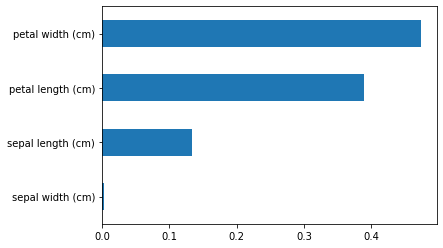

In [124]:
array = rf_clf2.feature_importances_
s = pd.Series(array,index=x.columns)
s.sort_values().plot(kind="barh")

In [79]:
x = df.drop(["target","sepal width (cm)"],axis  =1)
y = df["target"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [81]:
rf_f = RandomForestClassifier()

rf_clf.fit(x_train,y_train)
rf_clf.score(x_train,y_train)

1.0

In [82]:
rf_clf.score(x_test,y_test)

0.9

#### RMSc

In [84]:
rf_f = RandomForestClassifier()
parameter = {"n_estimators":np.arange(10,20),
                "criterion":["gini","entropy"],
                 "max_depth" :np.arange(4,10),
                 "min_samples_split":np.arange(3,10),
                 "min_samples_leaf":np.arange(3,10),
                 "max_features":["sqrt", "log2"],
                 "random_state":[41,42,43,44,45],
                 "oob_score":[True]}
rmcv_rf = RandomizedSearchCV(rf_clf,parameter,cv = 5)
rmcv_rf.fit(x_train,y_train)
rmcv_rf.best_estimator_


RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       min_samples_leaf=9, min_samples_split=4, n_estimators=15,
                       oob_score=True, random_state=43)

In [85]:
rf_clff = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       min_samples_leaf=9, min_samples_split=4, n_estimators=15,
                       oob_score=True, random_state=43)
rf_clff.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       min_samples_leaf=9, min_samples_split=4, n_estimators=15,
                       oob_score=True, random_state=43)

In [86]:
#training

y_pred_train = rf_clff.predict(x_train)

cnf_matrics = confusion_matrix(y_train,y_pred_train)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_train,y_pred_train)
print("accuracy ",accuracy)

cls_report = classification_report(y_train,y_pred_train)
print("classification report\n",cls_report)

confusion matrics
 [[40  0  0]
 [ 0 39  1]
 [ 0  3 37]]
accuracy  0.9666666666666667
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.93      0.97      0.95        40
           2       0.97      0.93      0.95        40

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



In [87]:
#testing

y_pred_test =rf_clff.predict(x_test)

cnf_matrics = confusion_matrix(y_test,y_pred_test)
print("confusion matrics\n",cnf_matrics)

accuracy = accuracy_score(y_test,y_pred_test)
print("accuracy ",accuracy)

cls_report = classification_report(y_test,y_pred_test)
print("classification report\n",cls_report)

confusion matrics
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
accuracy  0.9333333333333333
classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



## Fina Model

In [4]:
x = df.drop("target",axis = 1)
y = df["target"]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [5]:
knn_clf = KNeighborsClassifier()
parameter = {"n_neighbors": np.arange(2,20),
            "p":[1,2]}
gscv = GridSearchCV(knn_clf,parameter,cv = 5)
gscv.fit(x_train,y_train)
gscv.best_estimator_

KNeighborsClassifier(n_neighbors=6)

In [6]:
knn_clf1 = KNeighborsClassifier(n_neighbors=6)
knn_clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=6)

In [7]:
knn_clf1.score(x_train,y_train)

0.9666666666666667

In [8]:
knn_clf1.score(x_test,y_test)

0.9666666666666667

## user_input

In [9]:
project_data = {"columns":list(x.columns)}
project_data

{'columns': ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)']}

In [10]:
sepal_length = 6.1
sepal_width = 3.0
petal_length = 4.9
petal_width = 1.8

In [13]:
len(project_data["columns"])

4

In [14]:
test_array = np.zeros(len(project_data["columns"]))
test_array[0] = sepal_length
test_array[1] = sepal_width
test_array[2] = petal_length
test_array[3] = petal_width
knn_clf1.predict([test_array])[0]


2

In [15]:
y_pred = knn_clf1.predict(x_train)
y_pred

array([0, 1, 1, 0, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 2, 2, 0, 2, 0,
       2, 0, 1, 2, 2, 0, 2, 0, 0, 1, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 2, 0, 2, 0, 1, 2, 0, 2, 1,
       2, 1, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 2, 1, 0, 2, 1, 0, 2, 0, 2, 1,
       1, 0, 1, 2, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 2, 2, 0, 1, 1, 1, 1, 1,
       0, 2, 1, 1, 0, 0, 0, 0, 1, 0])

In [16]:
df_2 = pd.DataFrame(x_train)
df_2["y_actual"] = y_train
df_2["y_pred"] = y_pred
df_2

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y_actual,y_pred
8,4.4,2.9,1.4,0.2,0,0
106,4.9,2.5,4.5,1.7,2,1
76,6.8,2.8,4.8,1.4,1,1
9,4.9,3.1,1.5,0.1,0,0
89,5.5,2.5,4.0,1.3,1,1
...,...,...,...,...,...,...
37,4.9,3.6,1.4,0.1,0,0
2,4.7,3.2,1.3,0.2,0,0
33,5.5,4.2,1.4,0.2,0,0
52,6.9,3.1,4.9,1.5,1,1


In [21]:
import json
with open("json_data1.json","w") as f:
    json.dump(project_data,f)

In [18]:
import pickle
with open("knn_model.pkl","wb") as f:
    pickle.dump(knn_clf1,f)